In [35]:
# Import necessary libraries for data analysis and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import librosa
import librosa.display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [36]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for RAVDESS dataset
base_path_RAVDESS = "../data/raw/audio_speech_actors_01-24"
# Base path for TESS dataset
base_path_TESS = "../data/raw/TESS_Toronto_emotional_speech_set_data"

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
audio_files_tess = get_audio_files(base_path_TESS)
audio_files = audio_files_ravdess + audio_files_tess
# Save audio files paths
if not os.path.exists("../data/processed/audio_files.txt"):
    with open("../data/processed/audio_files.txt", "w") as f:
        for item in audio_files:
            f.write("%s\n" % item)
    print("../data/processed/audio_files.txt already exists is created")
else:
    print("../data/processed/audio_files.txt already exists")

../data/processed/audio_files.txt already exists


In [37]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files = []
with open("../data/processed/audio_files.txt", "r") as file:
    audio_files = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features = []
labels = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files, start=1):
        feature = extract_features(file)
        if feature is not None:
            features.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files)}")

    print("Feature extraction complete.")
    features = np.array(features)
    np.save("../data/processed/features.npy", features)
    labels = np.array(labels)
    np.save("../data/processed/labels.npy", labels)  
else:
    # Load features and labels
    features = np.load("../data/processed/features.npy")
    labels = np.load("../data/processed/labels.npy")

In [51]:
len(features)

187

In [38]:
# Convert features and labels to a DataFrame
df = pd.DataFrame(features)
df["label"] = labels

# Display the first few rows of the DataFrame
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

            0          1         2          3         4         5         6  \
0 -697.792603  54.890041  0.663465  12.435786  7.733951  0.530750 -3.216631   
1 -692.855774  55.363899 -1.548319  16.038307  8.818810 -0.146586 -1.373392   
2 -691.587891  58.024662  0.159465  13.624650  5.374112  1.162336 -2.083360   
3 -685.105469  55.879421  2.783262  13.252024  6.989668  2.981274 -1.586029   
4 -727.104370  62.355034  3.121181  15.064671  8.132434  1.927084 -3.274656   

          7          8         9  ...       178           179        180  \
0 -3.159395 -10.977551 -2.848711  ...  0.000004  3.206722e-07  19.063416   
1 -5.293180 -11.623182 -1.348284  ...  0.000004  3.190813e-07  19.701801   
2 -5.382585 -10.332824 -3.662081  ...  0.000013  1.119756e-06  18.740107   
3 -6.961661 -10.348489 -3.270769  ...  0.000018  1.238117e-06  20.502032   
4 -3.761792  -9.750299 -4.853837  ...  0.000002  1.941219e-07  18.376673   

         181        182        183        184        185        186 

In [39]:
# Convert features and labels to a DataFrame
df = pd.DataFrame(features)
df["label"] = labels

In [40]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df.drop(columns=["label"]))

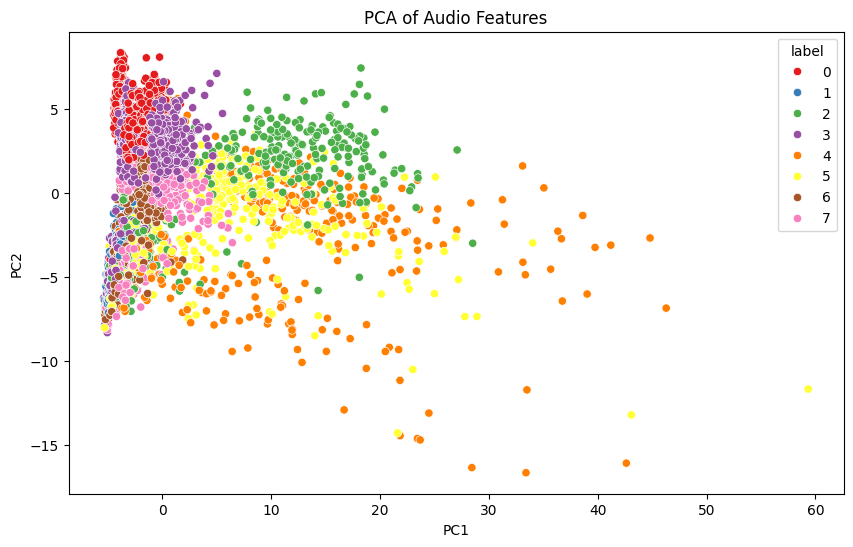

In [41]:
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["label"] = df["label"]

# Plot PCA results
plt.figure(figsize=(10, 6))
sn.scatterplot(x="PC1", y="PC2", hue="label", data=pca_df, palette="Set1")
plt.title("PCA of Audio Features")
plt.show()

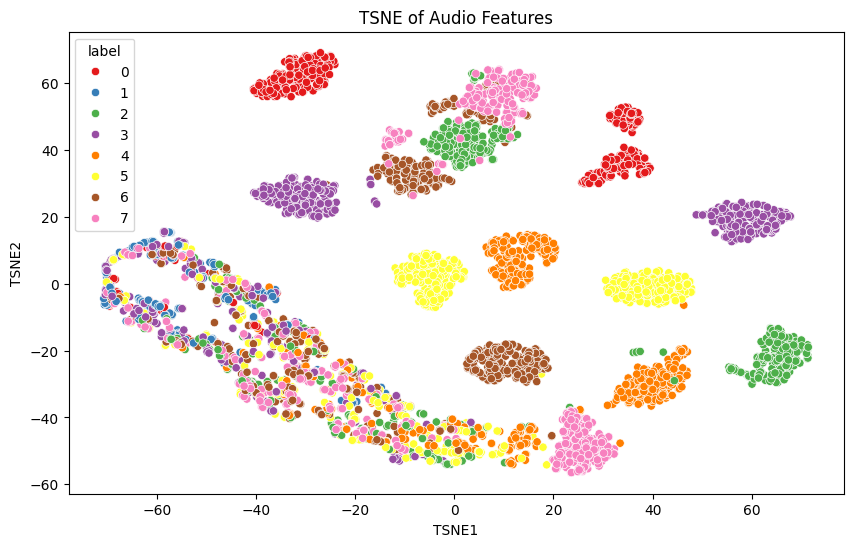

In [42]:
# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsene_result = tsne.fit_transform(df.drop(columns=["label"]))

# Create a DataFrame for PCA results
tsne_df = pd.DataFrame(tsene_result, columns=["TSNE1", "TSNE2"])
tsne_df["label"] = df["label"]

# Plot tsne results
plt.figure(figsize=(10, 6))
sn.scatterplot(x="TSNE1", y="TSNE2", hue="label", data=tsne_df, palette="Set1")
plt.title("TSNE of Audio Features")
plt.show()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


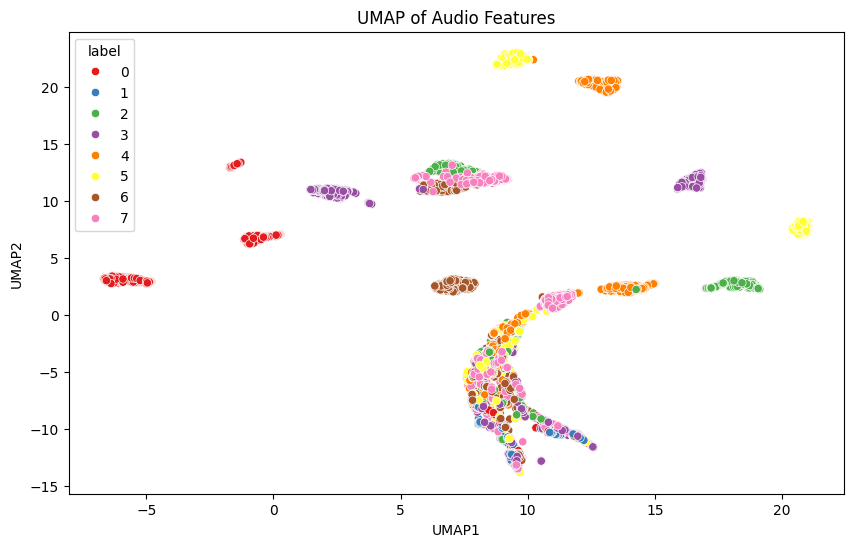

In [43]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(features)

# Create a DataFrame for PCA results
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["label"] = df["label"]

# Plot UMAP results
plt.figure(figsize=(10, 6))
sn.scatterplot(x="UMAP1", y="UMAP2", hue="label", data=umap_df, palette="Set1")
plt.title("UMAP of Audio Features")
plt.show()

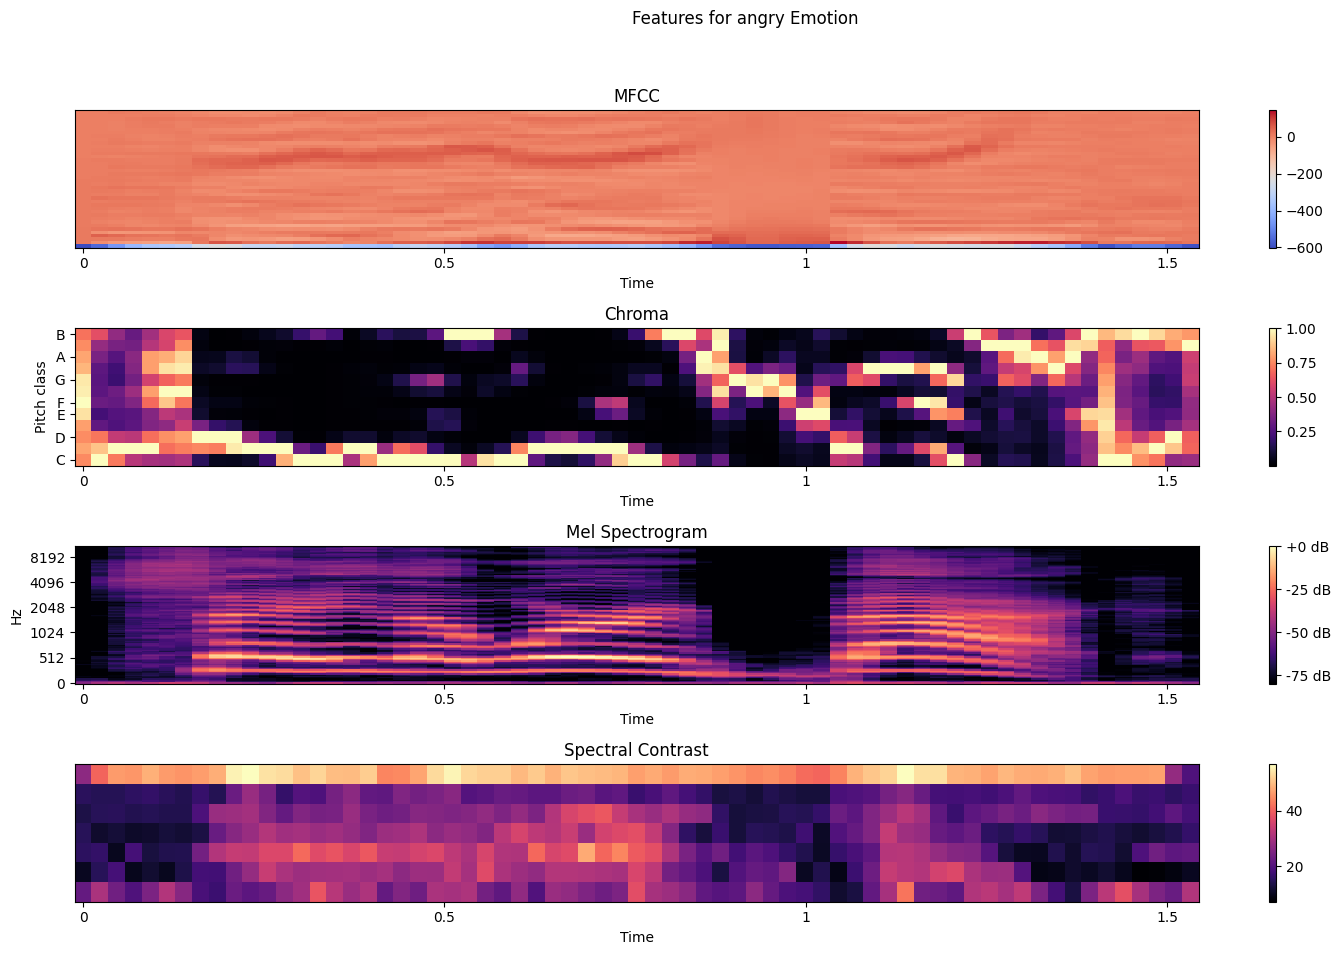

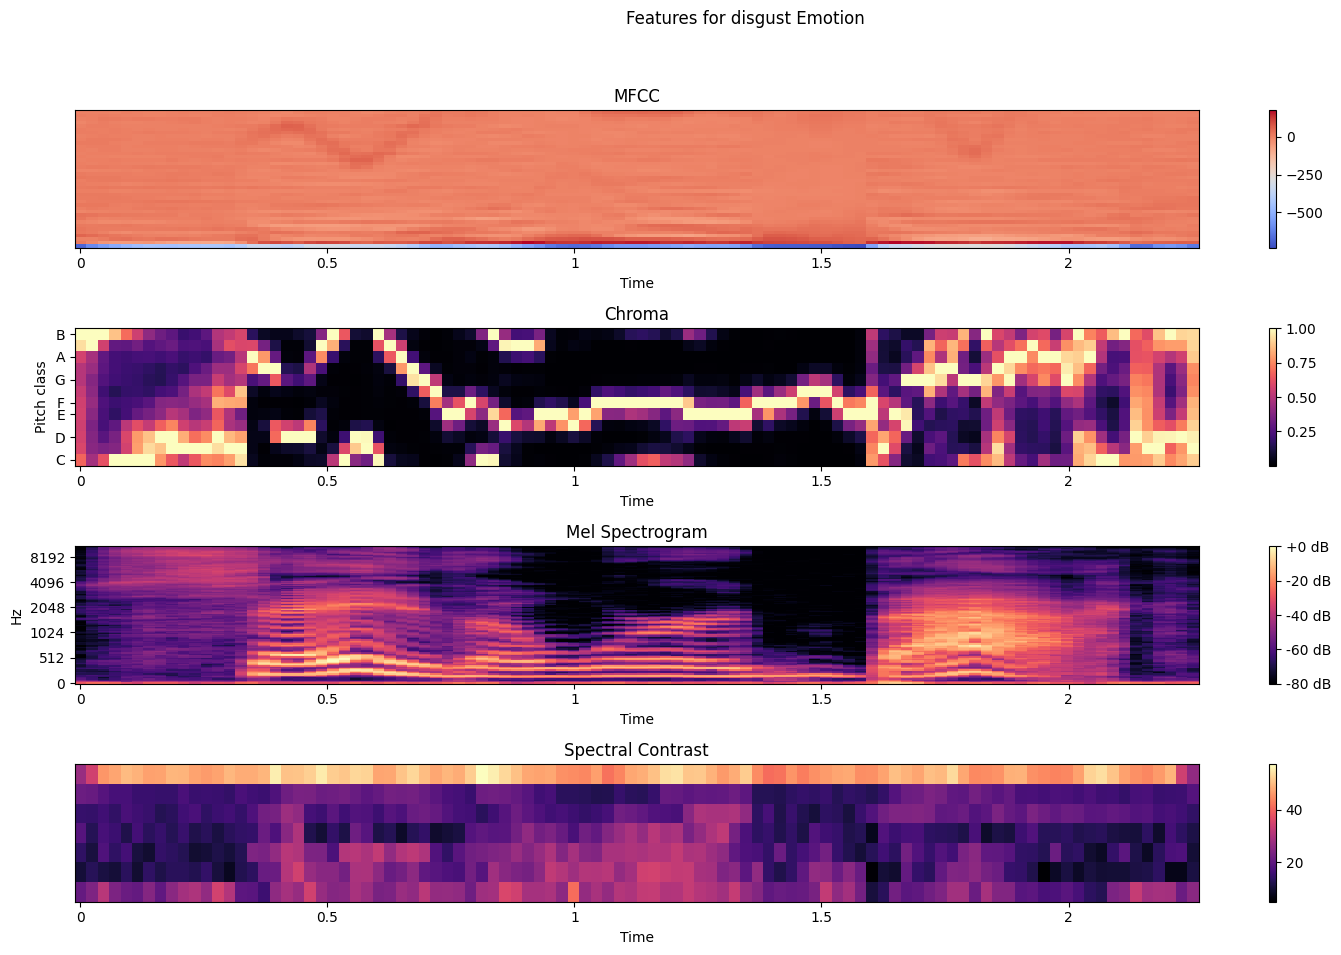

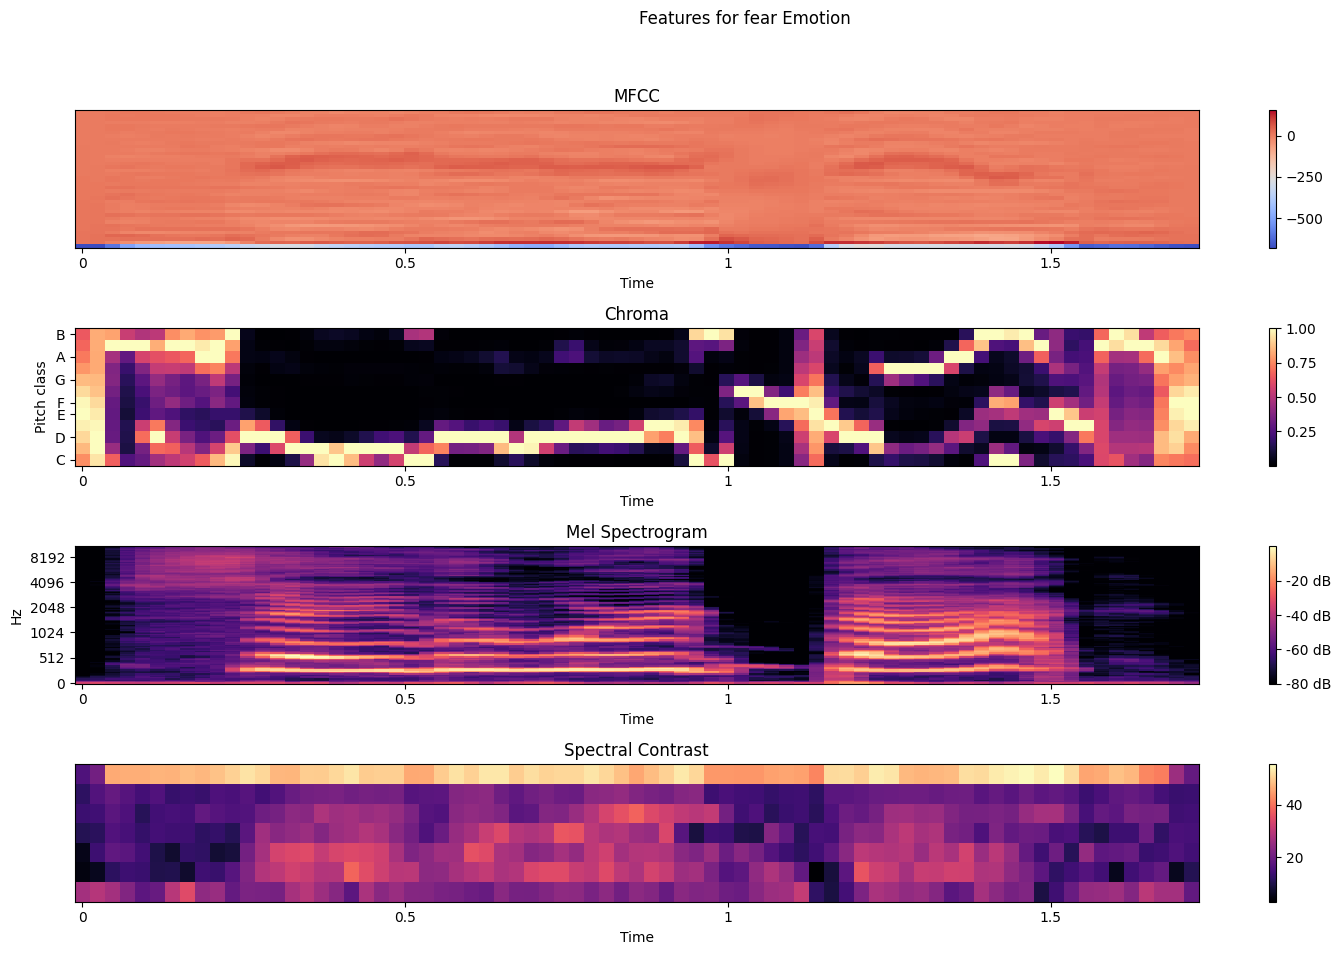

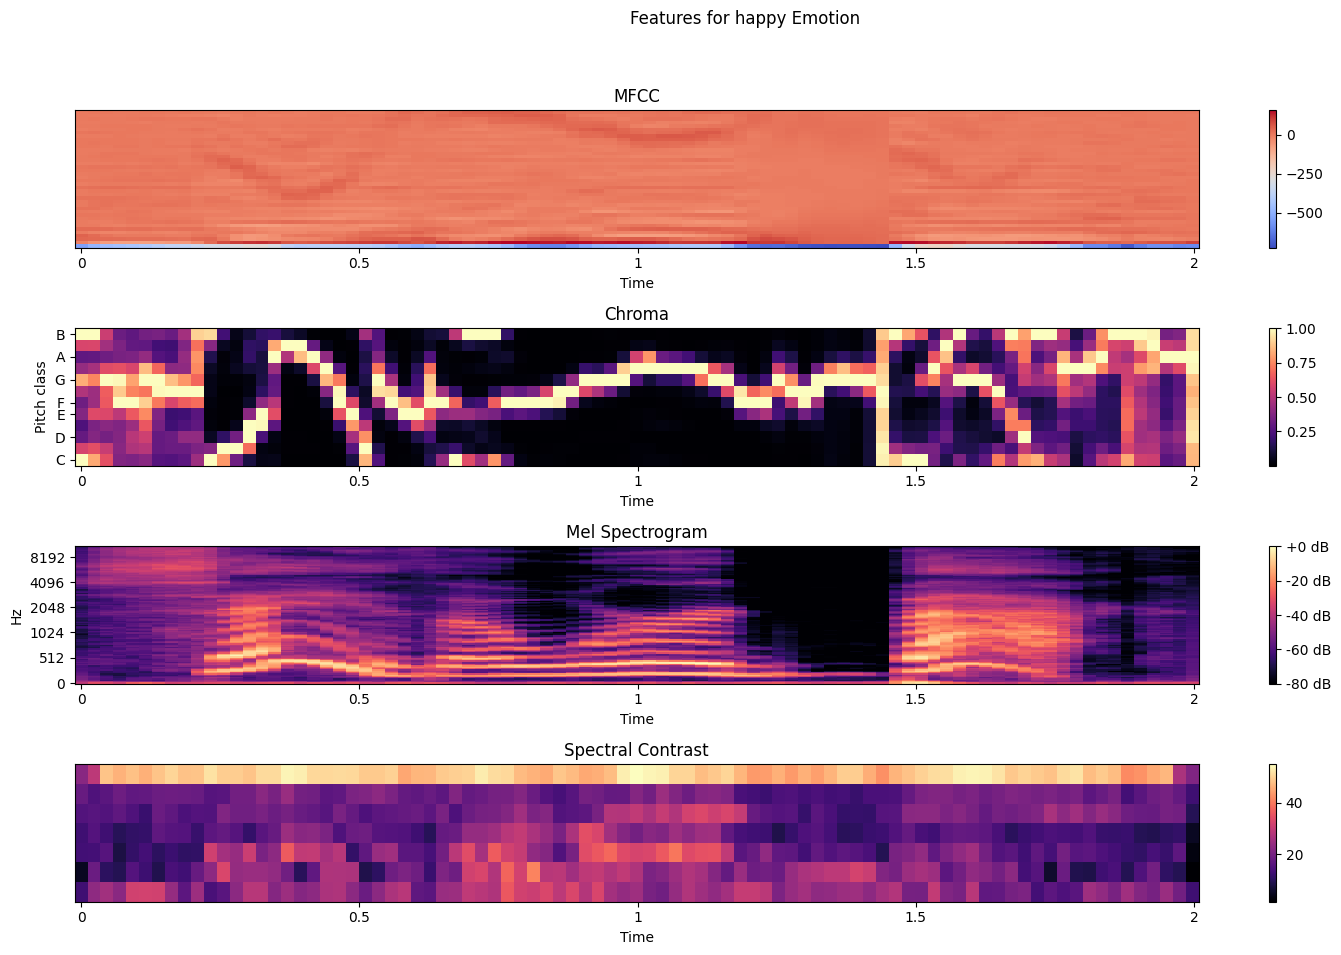

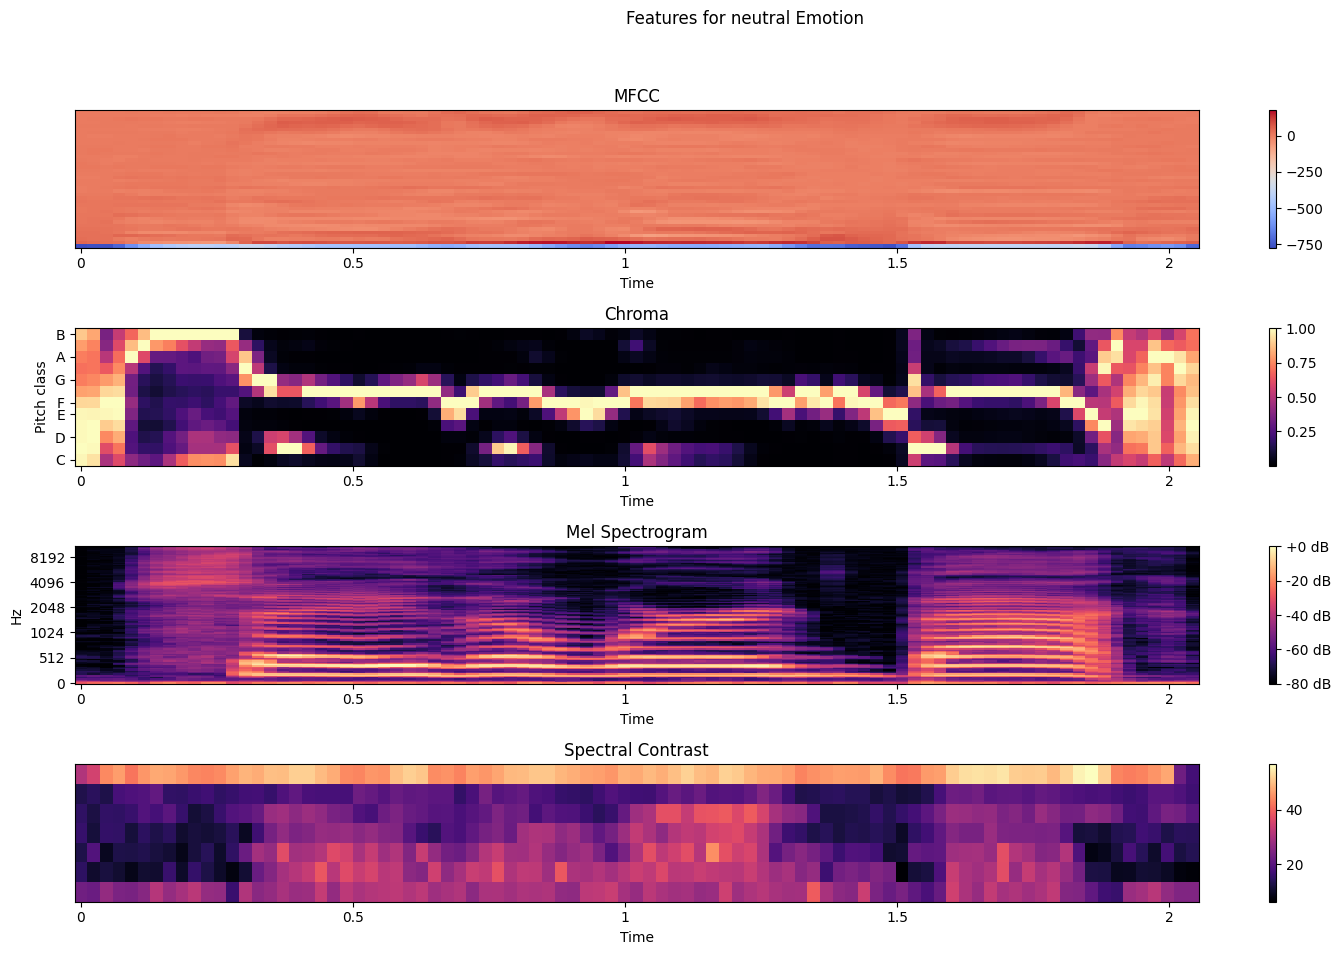

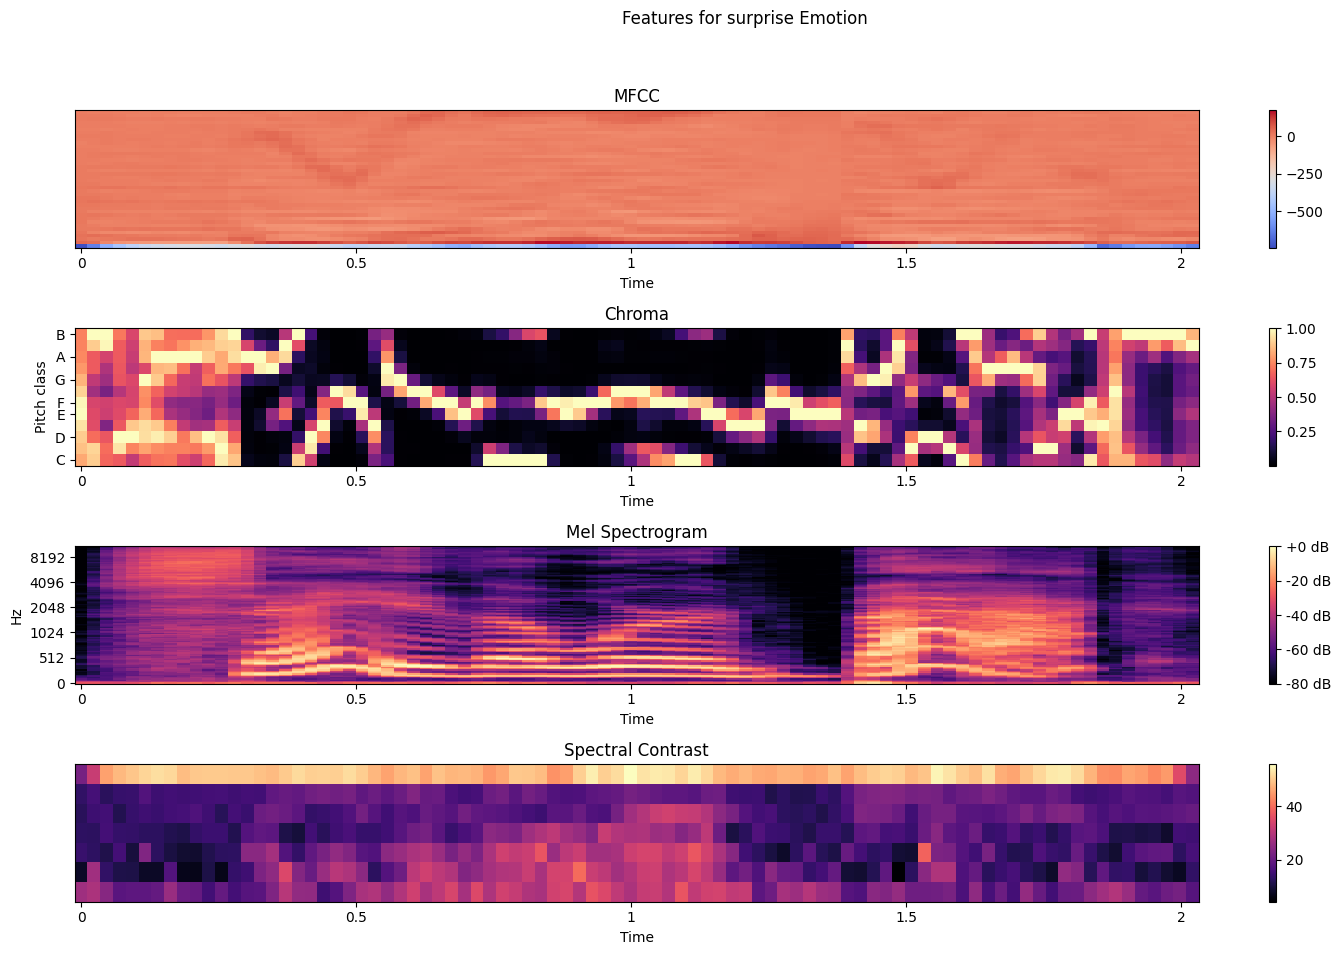

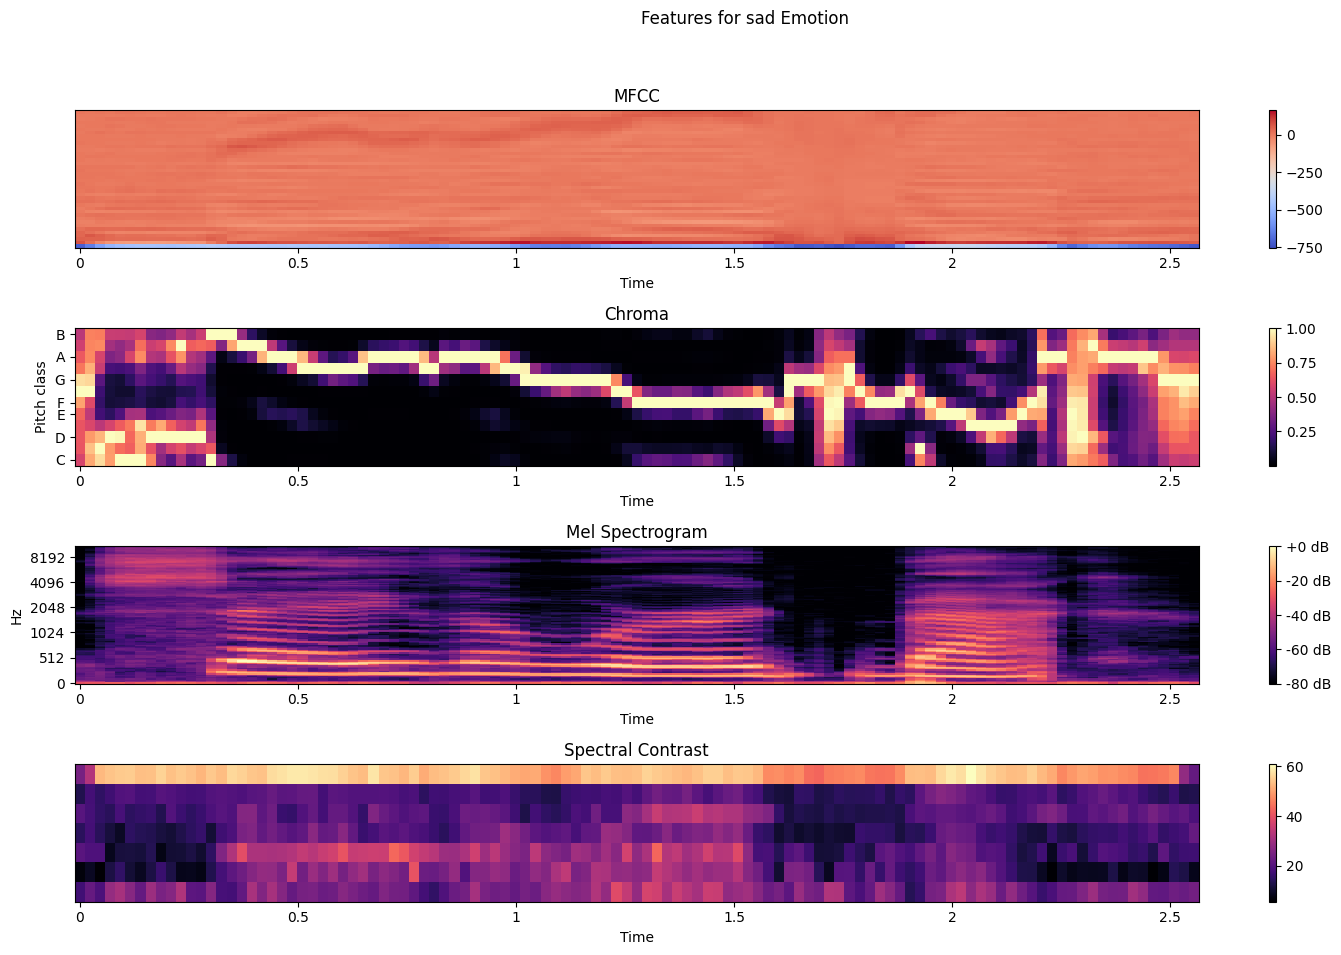

In [54]:
# Dictionary of samples
samples = {
    "angry": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_angry/OAF_back_angry.wav",
    "disgust": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_disgust/OAF_back_disgust.wav",
    "fear": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_Fear/OAF_back_fear.wav",
    "happy": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_happy/OAF_back_happy.wav",
    "neutral": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_neutral/OAF_back_neutral.wav",
    "surprise": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_Pleasant_surprise/OAF_back_ps.wav",
    "sad": "../data/raw/TESS_Toronto_emotional_speech_set_data/OAF_Sad/OAF_back_sad.wav",
}
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features_vis(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        return mfccs, chroma, mel, contrast
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, {str(e)}")
        return None, None, None, None


# Function to plot features
def plot_features(emotion, mfccs, chroma, mel, contrast):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Features for {emotion} Emotion")

    plt.subplot(4, 1, 1)
    librosa.display.specshow(mfccs, x_axis="time")
    plt.colorbar()
    plt.title("MFCC")

    plt.subplot(4, 1, 2)
    librosa.display.specshow(chroma, y_axis="chroma", x_axis="time")
    plt.colorbar()
    plt.title("Chroma")

    plt.subplot(4, 1, 3)
    librosa.display.specshow(
        librosa.power_to_db(mel, ref=np.max), y_axis="mel", x_axis="time"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")

    plt.subplot(4, 1, 4)
    librosa.display.specshow(contrast, x_axis="time")
    plt.colorbar()
    plt.title("Spectral Contrast")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Extract and plot features for each sample
for emotion, file_path in samples.items():
    mfccs, chroma, mel, contrast = extract_features_vis(file_path)
    if (
        mfccs is not None
        and chroma is not None
        and mel is not None
        and contrast is not None
    ):
        plot_features(emotion, mfccs, chroma, mel, contrast)